## 273 - How to Magically Save Storage Space for Maps


[Youtube](https://www.youtube.com/watch?v=fzhAseXp5B4)

In [1]:
from datetime import datetime

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
from metpy.units import units
import numpy as np
from scipy.ndimage import gaussian_filter
import xarray as xr

In [2]:
ds = xr.open_dataset('https://thredds.ucar.edu/thredds/dodsC/casestudies/'
                     'python-gallery/NAM_20161031_1200.nc')
ds.coords

Coordinates:
  * time                  (time) datetime64[ns] 2016-10-31T12:00:00
  * isobaric              (isobaric) float32 50.0 75.0 100.0 ... 975.0 1e+03
  * y                     (y) float32 -832.2 -820.0 ... 4.361e+03 4.373e+03
  * x                     (x) float32 -4.224e+03 -4.211e+03 ... 3.249e+03
  * height_above_ground1  (height_above_ground1) float32 2.0 80.0
  * height_above_ground   (height_above_ground) float32 2.0
  * height_above_ground3  (height_above_ground3) float32 10.0 80.0

In [3]:
# Grab lat/lon values (NAM will be 2D)
lats = ds.lat.data
lons = ds.lon.data

# Select and grab data
hght = ds['Geopotential_height_isobaric']
uwnd = ds['u-component_of_wind_isobaric']
vwnd = ds['v-component_of_wind_isobaric']

# Select and grab 500-hPa geopotential heights and wind components, smooth with gaussian_filter
hght_500 = gaussian_filter(hght.sel(isobaric=500).data[0], sigma=3.0)
uwnd_500 = gaussian_filter(uwnd.sel(isobaric=500).data[0], sigma=3.0) * units('m/s')
vwnd_500 = gaussian_filter(vwnd.sel(isobaric=500).data[0], sigma=3.0) * units('m/s')

# Use MetPy to calculate the wind speed for colorfill plot, change units to knots from m/s
sped_500 = mpcalc.wind_speed(uwnd_500, vwnd_500).to('kt')

# Create a clean datetime object for plotting based on time of Geopotential heights
vtime = datetime.strptime(str(ds.time.data[0].astype('datetime64[ms]')),
                          '%Y-%m-%dT%H:%M:%S.%f')

In [4]:
# Set up the projection that will be used for plotting
mapcrs = ccrs.LambertConformal(central_longitude=-100,
                               central_latitude=35,
                               standard_parallels=(30, 60))

# Set up the projection of the data; if lat/lon then PlateCarree is what you want
datacrs = ccrs.PlateCarree()

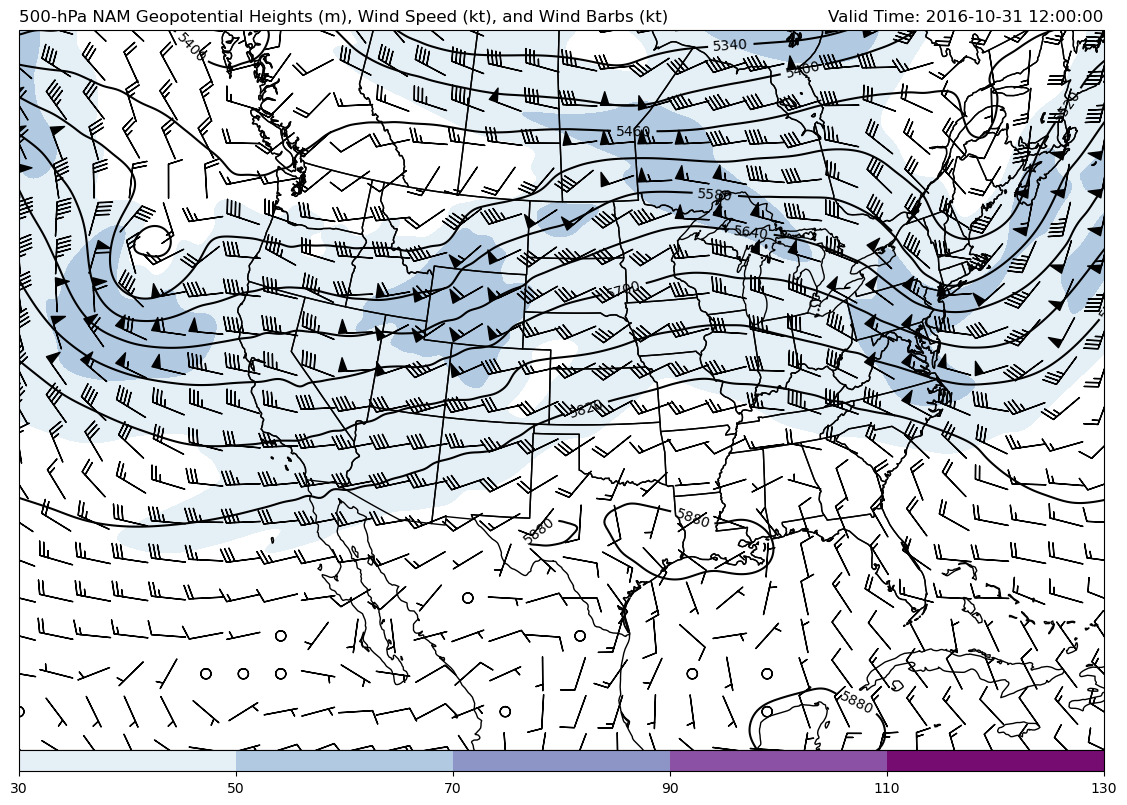

In [11]:
# Start the figure and create plot axes with proper projection
fig = plt.figure(1, figsize=(14, 12))
ax = plt.subplot(111, projection=mapcrs)
ax.set_extent([-130, -72, 20, 55], ccrs.PlateCarree())

# Add geopolitical boundaries for map reference
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.STATES.with_scale('50m'))

# Plot 500-hPa Colorfill Wind Speeds in knots
clevs_500_sped = np.arange(30, 150, 20)
cf = ax.contourf(lons, lats, sped_500, clevs_500_sped, cmap=plt.cm.BuPu,
                 transform=datacrs)
plt.colorbar(cf, orientation='horizontal', pad=0, aspect=50)

# Plot 500-hPa Geopotential Heights in meters
clevs_500_hght = np.arange(0, 8000, 60)
cs = ax.contour(lons, lats, hght_500, clevs_500_hght, colors='black',
                transform=datacrs)
plt.clabel(cs, fmt='%d')

# Plot 500-hPa wind barbs in knots, regrid to reduce number of barbs
ax.barbs(lons, lats, uwnd_500.to('kt').m, vwnd_500.to('kt').m, pivot='middle',
         color='black', regrid_shape=20, transform=datacrs)

# Make some nice titles for the plot (one right, one left)
plt.title('500-hPa NAM Geopotential Heights (m), Wind Speed (kt),'
          ' and Wind Barbs (kt)', loc='left')
plt.title('Valid Time: {}'.format(vtime), loc='right')

# Adjust image and show
plt.subplots_adjust(bottom=0, top=1)

plt.savefig('map_clipped.png', bbox_inches='tight')

In [14]:
from PIL import Image
im = Image.open('map_clipped.png')

In [15]:
im2 = im.convert('RGB').convert('P', palette=Image.Palette.ADAPTIVE)
im2.save('map_clipped_converted_rgb_adaptive.png')

In [17]:
im2 = im.convert('RGB').convert('P', palette=Image.Palette.WEB)
im2.save('map_clipped_converted_rgb_web.png')

In [19]:
im2 = im.convert('P', palette=Image.Palette.ADAPTIVE)
im2.save('map_clipped_converted_adaptive.png')

In [6]:
from pathlib import Path

In [20]:
print(f'Original Map {Path("map.png").stat().st_size / 1024 :.1f} kB')
print(f'Clipped Map {Path("map_clipped.png").stat().st_size / 1024 :.1f} kB')
print(f'Clipped Map RGB and Adaptive Converted {Path("map_clipped_converted_rgb_adaptive.png").stat().st_size / 1024 :.1f} kB')
print(f'Clipped Map RGB and Web Converted {Path("map_clipped_converted_rgb_web.png").stat().st_size / 1024 :.1f} kB')
print(f'Clipped Map Adaptive Converted {Path("map_clipped_converted_adaptive.png").stat().st_size / 1024 :.1f} kB')

Original Map 552.6 kB
Clipped Map 529.8 kB
Clipped Map RGB and Adaptive Converted 182.5 kB
Clipped Map RGB and Web Converted 175.7 kB
Clipped Map Adaptive Converted 128.8 kB
